In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import os
import zipfile

from pathlib import Path

import requests
import numpy as np

from torch import nn
from torchvision import transforms
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
print(torch.__version__)
print(torch.version.cuda)

2.3.1+cu121
12.1


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Input and Output Paths

In [4]:
denoised_oct_training_dataset = "D:/VIP Cup/Output dataset/denoised_pkl_dataset"
results = "D:/VIP Cup/Output dataset/classification_results"

Function for open a pickle file

In [5]:
import pickle

def open_pickle(path_to_pkl):

    with open(path_to_pkl, 'rb') as file:
        loaded_vol_oct = pickle.load(file)

    return loaded_vol_oct

In [6]:
import random
from sklearn.model_selection import train_test_split

def split_train_test_data(dataset, test_ratio: float):
    """
    Split the dataset into training and testing datasets.

    Parameters:
    - dataset: The dataset to be split.
    - test_ratio: The ratio of the testing dataset size to the total dataset size.

    Returns:
    - train_dataset: The training dataset as paths.
    - test_dataset: The testing dataset as paths.
    """

    random.seed(42)
    train_dataset, test_dataset = [],[]

    labels = os.listdir(dataset)
    for label in labels:
        label_path = os.path.join(dataset, label)
        vol_images = os.listdir(label_path)
        train_images, test_images = train_test_split(vol_images, test_size=test_ratio, random_state=42)
        train_image_count = len(train_images)
        test_image_count = len(test_images)

        for train_image in train_images:
            train_dataset.append(os.path.join(label_path, train_image))
        for test_image in test_images:
            test_dataset.append(os.path.join(label_path, test_image))

        print(f"class {label} has {train_image_count} training images and {test_image_count} testing images.")
        

    return train_dataset, test_dataset, labels

In [7]:
train_dataset_path, test_dataset_path, classes = split_train_test_data(denoised_oct_training_dataset, test_ratio=0.1667)
print()
print(f"Number of training samples: {len(train_dataset_path)}")
print(f"Number of testing samples: {len(test_dataset_path)}")

class 0 has 34 training images and 8 testing images.
class 1 has 24 training images and 6 testing images.
class 2 has 23 training images and 5 testing images.

Number of training samples: 81
Number of testing samples: 19


In [8]:
train_dataset_path

['D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (37).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (15).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (34).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (20).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (25).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (18).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (23).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (4).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (24).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (42).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (41).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (1).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (31).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl

In [9]:
test_dataset_path

['D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (32).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (21).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (17).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (33).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (13).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (7).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (27).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\0\\RawDataQA (36).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (7).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (23).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (30).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (25).pkl',
 'D:/VIP Cup/Output dataset/denoised_pkl_dataset\\1\\RawDataQA-1 (17).pkl',
 'D:/VIP Cup/Output dataset/de

Creating the volumetric dataset

In [10]:
def create_vol_datasets(dataset):
    """load pickle files as a numpy array associated with their labels and return them as a dataset"""
    
    dataset_list = []
    for path in dataset:
        vol_oct = open_pickle(path)
        label = os.path.basename(os.path.dirname(path))
        dataset_list.append((vol_oct, label))
    return dataset_list

In [11]:
train_vol_dataset = create_vol_datasets(train_dataset_path)
test_vol_dataset = create_vol_datasets(test_dataset_path)

In [12]:
len(train_vol_dataset), len(test_vol_dataset)

(81, 19)

Creating 2D sclices of dataset from 

In [13]:
def create_2D_dataset(vol_dataset):
    """create a 2D dataset from the 3D dataset"""
    
    dataset_2D = []
    for vol_oct, label in vol_dataset:
        m = vol_oct.shape[2]
        for i in range(m):
            dataset_2D.append((vol_oct[:,:,i], label))
    return dataset_2D

In [14]:
train_dataset = create_2D_dataset(train_vol_dataset)
test_dataset = create_2D_dataset(test_vol_dataset)


In [15]:
training_cases = len(train_dataset)
testing_cases = len(test_dataset)
total_cases = training_cases + testing_cases
test_ratio = testing_cases / total_cases

print(f"Number of training samples: {training_cases}")
print(f"Number of testing samples: {testing_cases}")
print(f"Number of total samples: {total_cases}")
print(f"Ratio of the testing dataset size to the total dataset size: {test_ratio:.4f}")
print(f"Sample shape of the training data: {train_dataset[0][0].shape}")

Number of training samples: 14698
Number of testing samples: 3340
Number of total samples: 18038
Ratio of the testing dataset size to the total dataset size: 0.1852
Sample shape of the training data: (300, 300)


Class Names

In [16]:
classes

['0', '1', '2']

In [17]:
class_names = {classes[0]: "Normal", classes[1]: "Diabetes", classes[2]: "non-Diabetes"}
class_names

{'0': 'Normal', '1': 'Diabetes', '2': 'non-Diabetes'}

We are intending to use ResNet-34 for the classification task. We will use the pre-trained model.

Creating the transforms

In [18]:
#Get a set of pretrained model weights

# Get the weights
weights = torchvision.models.ResNet34_Weights.DEFAULT  
weights 

ResNet34_Weights.IMAGENET1K_V1

In [19]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Create manual transforms to include the RGB conversion also

In [20]:
from PIL import Image
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode

class GrayscaleToRGB:
    def __call__(self, image):
        if image.ndim == 2:  # Grayscale image
            # Scale float values to [0, 255] and convert to uint8
            img = (image * 255).astype(np.uint8)
            # Stack to create a 3-channel RGB image
            img = np.stack((img,) * 3, axis=-1)
            img2 = Image.fromarray(img)
        else:  # RGB image
            # Scale float values to [0, 255] and convert to uint8
            img = (image * 255).astype(np.uint8)
            img2 = Image.fromarray(img)
        return img2

crop_size = 300
resize_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
interpolation = InterpolationMode.BILINEAR

final_transform = transforms.Compose([
    GrayscaleToRGB(),
    #transforms.CenterCrop(crop_size),
    transforms.Resize(resize_size, interpolation=interpolation),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

testing

In [21]:
#`sample` is a numpy array representing a grayscale image
sample = train_dataset[0][0]

# Apply the final transformation
a = final_transform(sample)
a

tensor([[[-0.5424, -0.4226, -0.3541,  ..., -0.4054, -0.4911, -0.4054],
         [-0.5424, -0.4226, -0.3369,  ..., -0.4054, -0.4911, -0.4054],
         [-0.5253, -0.4226, -0.3369,  ..., -0.3883, -0.4568, -0.3883],
         ...,
         [ 0.0227, -0.0458, -0.0116,  ...,  0.1426,  0.0912,  0.1254],
         [ 0.0398, -0.0458,  0.0056,  ...,  0.1426,  0.1083,  0.1254],
         [ 0.0569, -0.0116,  0.0398,  ...,  0.1426,  0.1254,  0.1254]],

        [[-0.4251, -0.3025, -0.2325,  ..., -0.2850, -0.3725, -0.2850],
         [-0.4251, -0.3025, -0.2150,  ..., -0.2850, -0.3725, -0.2850],
         [-0.4076, -0.3025, -0.2150,  ..., -0.2675, -0.3375, -0.2675],
         ...,
         [ 0.1527,  0.0826,  0.1176,  ...,  0.2752,  0.2227,  0.2577],
         [ 0.1702,  0.0826,  0.1352,  ...,  0.2752,  0.2402,  0.2577],
         [ 0.1877,  0.1176,  0.1702,  ...,  0.2752,  0.2577,  0.2577]],

        [[-0.2010, -0.0790, -0.0092,  ..., -0.0615, -0.1487, -0.0615],
         [-0.2010, -0.0790,  0.0082,  ..., -0

In [22]:
a.shape

torch.Size([3, 224, 224])

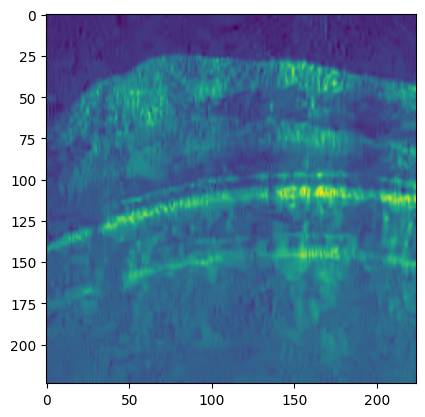

In [23]:
plt.imshow(a[2,:,:])

In [24]:
train_dataset[0]

(array([[0.3602106 , 0.36963236, 0.40482548, ..., 0.36588416, 0.38754609,
         0.39784697],
        [0.36010915, 0.36944386, 0.40498698, ..., 0.36151809, 0.38983473,
         0.39774218],
        [0.36048073, 0.37109655, 0.40413761, ..., 0.360349  , 0.39183092,
         0.39884546],
        ...,
        [0.50629044, 0.4697457 , 0.48424375, ..., 0.51213938, 0.51351953,
         0.51544142],
        [0.51053566, 0.47276598, 0.48769131, ..., 0.51471663, 0.51600945,
         0.51488155],
        [0.51183861, 0.47449845, 0.49121377, ..., 0.51666921, 0.51870942,
         0.51389706]]),
 '0')

In [25]:
train_dataset[0][0].shape, train_dataset[0][1]

((300, 300), '0')

Creating datasetss and applying transforms

In [26]:
def one_hot_encode(label, num_classes):
    torch_label = torch.tensor(int(label))
    return torch.nn.functional.one_hot(torch_label, num_classes).float()


In [27]:
def create_preprocessed_datasets(dataset, dataset_name:str):
    """create datasets using the CustomDataset class"""

    data, targets = [], []
    num_classes = len(classes)

    for i in range(len(dataset)):
        data_array = dataset[i][0]
        transformed_data = final_transform(data_array)
        data.append(transformed_data)

        target = dataset[i][1]
        label = one_hot_encode(label=target, num_classes=num_classes)
        targets.append(label)

    print(f"Number of {dataset_name} samples: {len(data)}")
    print(f"Number of {dataset_name} targets: {len(targets)}")
    print(f"Number of {dataset_name} datapoints in input list: {len(dataset)}")
    print(f"Sample of {dataset_name} data: {data[0]}")
    print(f"Sample of {dataset_name} data shape:{data[0].shape}")
    print(f"Sample of {dataset_name} target: {targets[0]}")
    print(f"Sample of {dataset_name} target shape: {targets[0].shape}")

    return data, targets

Creating train and test datasets

In [28]:
train_data, train_targets = create_preprocessed_datasets(train_dataset, "training dataset")
test_data, test_targets = create_preprocessed_datasets(test_dataset, "testing dataset")

Creating custom datasets

In [ ]:
from torch.utils.data import TensorDataset

def create_dataset(data_tensor, target_tensor):
    dataset = TensorDataset(data_tensor, target_tensor)
    return dataset

In [ ]:
# Step 1: Convert lists to tensors
train_data_tensor = torch.stack(train_data)
print(f"train_data_tensor shape: {train_data_tensor.shape}")

train_targets_tensor = torch.stack(train_targets)
print(f"train_targets_tensor shape: {train_targets_tensor.shape}")

test_data_tensor = torch.stack(test_data)
print(f"test_data_tensor shape: {test_data_tensor.shape}")

test_targets_tensor = torch.stack(test_targets)
print(f"test_targets_tensor shape: {test_targets_tensor.shape}")

train_data_tensor shape: torch.Size([14698, 3, 224, 224])
train_targets_tensor shape: torch.Size([14698, 3])
test_data_tensor shape: torch.Size([3340, 3, 224, 224])
test_targets_tensor shape: torch.Size([3340, 3])


In [ ]:
train_dataset =  create_dataset(train_data_tensor, train_targets_tensor)
test_dataset = create_dataset(test_data_tensor, test_targets_tensor)

In [ ]:
train_dataset, test_dataset

(<torch.utils.data.dataset.TensorDataset at 0x1b2691ed410>,
 <torch.utils.data.dataset.TensorDataset at 0x1b222d23450>)

Creating DataLoaders

In [ ]:
import os
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dataset,
    test_dataset, 
    batch_size,
    num_workers=0
):
    # Create DataLoaders
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle= True,
        num_workers = num_workers,
        pin_memory = True
    )

    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle= False,
        num_workers = num_workers,
        pin_memory = True
    )

    return train_dataloader, test_dataloader

In [ ]:
train_dataloader, test_dataloader = create_dataloaders(train_dataset=train_dataset, 
                                                      test_dataset=test_dataset, 
                                                      batch_size=32)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1b269220350>,
 <torch.utils.data.dataloader.DataLoader at 0x1b27fe19810>)

Iterating through dataloaders

In [ ]:
for X_batch, y_batch in train_dataloader:
    print("Shape of the first element in X_batch:", X_batch.shape)
    print("Shape of the first element in y_batch:", y_batch.shape)
    break  # Just to print the first batch and stop

Shape of the first element in X_batch: torch.Size([32, 3, 224, 224])
Shape of the first element in y_batch: torch.Size([32, 3])


Getting pre-trained model

In [ ]:
#ResNet-101 model
weights = torchvision.models.ResNet34_Weights.DEFAULT
model = torchvision.models.resnet34(weights=weights).to(device)

In [ ]:
#Summary of  the ResNet-101
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

Freezing feature layers and creating new classifier layer

In [ ]:
#freeze all layers
for param in model.parameters():
    param.requires_grad = False

#Replacing final fully connected layer
model.fc = torch.nn.Sequential(
    nn.Linear(in_features=512, out_features=3),
    #nn.ReLU(),
    #nn.Linear(in_features=256, out_features=3),
    nn.Softmax()
)

#unfreeze final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

#unfreeze the last 2 layers
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True

Model Summary

In [ ]:
#Summary of  the ResNet-101
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

Accuracy function

In [ ]:
import torchmetrics
import torchmetrics.classification

TASK = 'multiclass'
NUM_CLASSES = 3

device = "cuda" if torch.cuda.is_available() else "cpu"

def accuracy(y_true, y_pred):
    accuracy = torchmetrics.Accuracy(task = TASK, num_classes=NUM_CLASSES).to(device)
    return accuracy(y_pred, y_true)

def precision(y_true, y_pred):
    precision = torchmetrics.Precision(task = TASK, num_classes=NUM_CLASSES).to(device)
    return precision(y_pred, y_true)

def sensitivity(y_true, y_pred):
    sensitivity = torchmetrics.Recall(task = TASK, num_classes=NUM_CLASSES).to(device)
    return sensitivity(y_pred, y_true)

def specificity(y_true, y_pred):
    specificity = torchmetrics.Specificity(task = TASK, num_classes=NUM_CLASSES).to(device)
    return specificity(y_pred, y_true)

def f_score(y_true, y_pred):
    f_scaore = torchmetrics.F1Score(task = TASK, num_classes=NUM_CLASSES).to(device)
    return f_score(y_pred, y_true)

Train Model

In [ ]:
#define accuracy, loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Testing Purposes..


In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    
    """Train a PyTorch model for one epoch"""

    #training
    model.train()

    train_loss, train_accuracy = 0, 0

    #iterate over batches
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), (y_batch).to(device)

        #forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #calculate training loss
        train_loss += loss.item()

        #calculate training accuracy
        train_accuracy += accuracy(y_batch.to(torch.int), y_pred)

    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    return train_loss, train_accuracy

In [ ]:
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
    
    """Test a PyTorch model for one epoch"""

    #evaluation
    model.eval()

    test_loss, test_accuracy = 0, 0

    #disable gradient computation
    with torch.inference_mode():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            #forward pass
            test_preds = model(X_batch)

            loss = loss_fn(test_preds, y_batch)
            test_loss += loss.item()

            #calculate test accuracy
            test_accuracy += accuracy(y_batch.to(torch.int), test_preds)
            
        
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)

    return test_loss, test_accuracy

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          epochs: int):
    
    """Train a PyTorch model"""

    #Create empty results dictionary
    results = {
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }

    #loop throug trainning and testing epochs
    for epoch in tqdm(range(epochs)):
        #train step
        train_loss, train_accuracy = train_step(model, train_dataloader, loss_fn, optimizer, device)
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)

        #test step
        test_loss, test_accuracy = test_step(model, test_dataloader, loss_fn, device)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

        print(f"Epoch: {epoch+1}/{epochs}, train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, test_loss: {test_loss:.4f}, test_accuracy: {test_accuracy:.4f}")

    return results
    

In [ ]:
#Set the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

#setup training and save the results
results = train(model= model,
                train_dataloader= train_dataloader,
                test_dataloader= test_dataloader,
                loss_fn= loss_fn,
                optimizer= optimizer,
                device= device,
                epochs= 10)

# End the timer
end_time = timer()
execution_time = end_time - start_time
print(f"Execution time: {execution_time}")

Evaluating the model

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
import torch
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """
    Plots the loss curves of the training and test datasets.
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    accuracy = torch.tensor(results["train_accuracy"]).cpu()  # Convert to tensor and move to CPU
    test_accuracy = torch.tensor(results["test_accuracy"]).cpu()  # Convert to tensor and move to CPU
    
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


In [ ]:
plot_loss_curves(results)

In [ ]:
def predict_single_image(dataloader, model, device):
    """Predict the class of a single image using the trained model from test dataloader"""
    